<a href="https://colab.research.google.com/github/tiffchow214/churn_app_huggingface/blob/main/e_commerce_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gradio

In [2]:
import gradio as gr

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# === 0) setup & load  ===
import pandas as pd, numpy as np, json, re
csv_path = "/content/drive/MyDrive/data_ecommerce_customer_churn.csv"
df = pd.read_csv(csv_path)

In [5]:
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [6]:
df = df.copy()

Data Quality Check before Data Cleaning

In [7]:
# 1) schema & types
print("Shape:", df.shape)
display(df.head(3))
print("\nDtypes:\n", df.dtypes)

# 2) target check
if "Churn" in df.columns:
    vc = df["Churn"].value_counts(dropna=False)
    print("\nChurn counts:\n", vc)
    print("Churn rate:", (vc.get(1,0) / vc.sum() if vc.sum() else np.nan))

# 3) missingness
nulls = (
    df.isna().sum()
      .to_frame("missing")
      .assign(pct=lambda x: x["missing"] / len(df))
      .sort_values("pct", ascending=False)
)
print("\nTop missing:")
display(nulls.head(12))

# 4) split cols
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if pd.api.types.is_object_dtype(df[c])]
print("\n# numeric:", len(num_cols), "| # categorical:", len(cat_cols))

# 5) numeric sanity (negatives, bounds, outliers)
neg_cols = {c:int((df[c] < 0).sum()) for c in num_cols}
neg_cols = {k:v for k,v in neg_cols.items() if v>0}
print("\nNegatives found (rows):", neg_cols if neg_cols else "None")

if "SatisfactionScore" in df:
    ss = df["SatisfactionScore"]
    bad = ((ss < 1) | (ss > 5)).sum()
    print("SatisfactionScore outside [1,5]:", int(bad))

# outlier % beyond 1.5*IQR
outlier_report = []
for c in num_cols:
    s = df[c].dropna()
    if len(s) < 5: continue
    q1, q3 = s.quantile([0.25,0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    pct = ((s < low) | (s > high)).mean()
    if pct > 0.01:
        outlier_report.append((c, round(pct,4)))
print("Cols with >1% outliers (1.5*IQR):", outlier_report or "None")

# 6) categorical quality (cardinality, messy variants)
card = pd.DataFrame({
    "n_unique":[df[c].nunique(dropna=True) for c in cat_cols]
}, index=cat_cols).sort_values("n_unique", ascending=False)
print("\nCategorical cardinality:")
display(card)

def normalized_values(s):
    return s.astype(str).str.strip().str.lower()

for c in cat_cols:
    raw_uni = set(df[c].dropna().unique())
    norm_uni = set(normalized_values(df[c]).dropna().unique())
    if len(raw_uni) != len(norm_uni):
        print(f"Possible case/space duplicates in '{c}' → raw:{len(raw_uni)} vs normalized:{len(norm_uni)}")

# show top categories for a few important fields if present
for c in ["PreferedOrderCat","PreferredOrderCat","MaritalStatus","PreferredPaymentMode","PreferredLoginDevice","Gender"]:
    if c in df.columns:
        print(f"\nTop values for {c}:")
        display(df[c].value_counts().head(10))

# 7) duplicates (full-row and by key)
dup_rows = int(df.duplicated().sum())
print("\nFull-row duplicates:", dup_rows)
for key in ["CustomerID","CustomerId","customerid"]:
    if key in df.columns:
        key_dups = int(df.duplicated(subset=[key]).sum())
        print(f"Duplicates on {key}:", key_dups)

# 8) strong numeric correlations (|ρ| > 0.9)
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True).abs()
    high_pairs = []
    for i,c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1,c2]
            if r > 0.9:
                high_pairs.append((c1,c2,round(r,3)))
    print("\nHigh-corr numeric pairs (|rho|>0.9):", high_pairs or "None")


Shape: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0



Dtypes:
 Tenure                      float64
WarehouseToHome             float64
NumberOfDeviceRegistered      int64
PreferedOrderCat             object
SatisfactionScore             int64
MaritalStatus                object
NumberOfAddress               int64
Complain                      int64
DaySinceLastOrder           float64
CashbackAmount              float64
Churn                         int64
dtype: object

Churn counts:
 Churn
0    3267
1     674
Name: count, dtype: int64
Churn rate: 0.17102258310073584

Top missing:


,missing,pct
DaySinceLastOrder,213,0.054047
Tenure,194,0.049226
WarehouseToHome,169,0.042883
NumberOfDeviceRegistered,0,0.000000
PreferedOrderCat,0,0.000000
MaritalStatus,0,0.000000
SatisfactionScore,0,0.000000
NumberOfAddress,0,0.000000
Complain,0,0.000000
CashbackAmount,0,0.000000



# numeric: 9 | # categorical: 2

Negatives found (rows): None
SatisfactionScore outside [1,5]: 0
Cols with >1% outliers (1.5*IQR): [('NumberOfDeviceRegistered', np.float64(0.0688)), ('DaySinceLastOrder', np.float64(0.0115)), ('CashbackAmount', np.float64(0.0802)), ('Churn', np.float64(0.171))]

Categorical cardinality:


,n_unique
PreferedOrderCat,6
MaritalStatus,3



Top values for PreferedOrderCat:


,count
PreferedOrderCat,
Laptop & Accessory,1458
Mobile Phone,887
Fashion,585
Mobile,559
Grocery,273
Others,179



Top values for MaritalStatus:


,count
MaritalStatus,
Married,2055
Single,1310
Divorced,576



Full-row duplicates: 671

High-corr numeric pairs (|rho|>0.9): None


Data Cleaning

In [8]:
from pathlib import Path
df_raw = df.copy()
clean_df = df.copy()

actions = []

# 1) Drop exact duplicates ONLY if present
dup_ct = int(clean_df.duplicated().sum())
if dup_ct > 0:
    before = len(clean_df)
    clean_df = clean_df.drop_duplicates()
    actions.append(f"Dropped {before - len(clean_df)} exact duplicate rows.")
else:
    actions.append("No exact duplicate rows found.")

# 2) Normalize 'PreferedOrderCat' (unconditionally, robust to case/spacing)
if "PreferedOrderCat" in clean_df.columns:
    clean_df["PreferedOrderCat"] = (
        clean_df["PreferedOrderCat"]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)               # collapse double spaces
        .str.replace(r"(?i)^mobile$", "Mobile Phone", regex=True)  # 'mobile' -> 'Mobile Phone' (case-insensitive)
    )
    actions.append("Normalized PreferedOrderCat (Mobile → Mobile Phone).")
else:
    actions.append("PreferedOrderCat not present; skipped normalization.")

# 3) Missingness flags + median impute ONLY where still missing
#    Also harmonise your earlier flag DSLO_missing if you already created it.
def ensure_missing_flag_and_impute(col):
    made_flag = False; did_impute = False
    if col not in clean_df.columns:
        return made_flag, did_impute, f"{col} not present; skipped."
    # Honor an existing flag (either <col>_was_missing or your earlier DSLO_missing naming)
    alt_flag_map = {"DaySinceLastOrder": "DSLO_missing"}
    flag_col = f"{col}_was_missing"
    if flag_col not in clean_df.columns:
        if col in alt_flag_map and alt_flag_map[col] in clean_df.columns:
            # Reuse your existing DSLO_missing; also add the canonical flag for consistency
            clean_df[flag_col] = clean_df[alt_flag_map[col]].astype(int)
            actions_msg = f"Reused existing {alt_flag_map[col]} as {flag_col}."
        else:
            clean_df[flag_col] = clean_df[col].isna().astype(int)
            actions_msg = f"Created {flag_col}."
        made_flag = True
    else:
        actions_msg = f"{flag_col} already exists."

    if clean_df[col].isna().any():
        med = clean_df[col].median()
        clean_df[col] = clean_df[col].fillna(med)
        did_impute = True
        actions_msg += f" Imputed {col} with median={med:.2f}."
    else:
        actions_msg += f" No missing in {col}; no imputation needed."
    return made_flag, did_impute, actions_msg

for col in ["DaySinceLastOrder", "Tenure", "WarehouseToHome"]:
    _, _, msg = ensure_missing_flag_and_impute(col)
    actions.append(msg)

# 4) Enforce obvious bounds on SatisfactionScore ONLY if out-of-range values exist
if "SatisfactionScore" in clean_df.columns:
    ss = clean_df["SatisfactionScore"]
    bad = ((ss < 1) | (ss > 5)).sum()
    if bad > 0:
        clean_df["SatisfactionScore"] = ss.clip(1, 5)
        actions.append(f"Clipped {bad} out-of-range SatisfactionScore values to [1,5].")
    else:
        actions.append("SatisfactionScore already within [1,5]; no clipping.")
else:
    actions.append("SatisfactionScore not present; skipped bounds check.")

# 5) Persist the cleaned dataset for EDA + modeling
CLEAN_PATH = Path("/content/clean_ecommerce_churn_ready.csv")
clean_df.to_csv(CLEAN_PATH, index=False)

# 6) Build JSON meta for sklearn + Gradio (only from cleaned frame)
numeric_cols = [c for c in clean_df.columns if pd.api.types.is_numeric_dtype(clean_df[c]) and c != "Churn"]
categorical_cols = [c for c in clean_df.columns if clean_df[c].dtype == "object"]
ui_options = {c: sorted(clean_df[c].dropna().astype(str).unique().tolist()) for c in categorical_cols}

META_PATH = Path("/content/clean_meta_ready.json")
meta = {
    "target_col": "Churn",
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "ui_options": ui_options
}
with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print(f"Saved → {CLEAN_PATH} (rows: {len(clean_df)}, cols: {clean_df.shape[1]})")
print(f"Saved → {META_PATH}")

print("\n=== Actions taken ===")
for a in actions:
    print("•", a)

# Optional quick sanity peek
print("\nChurn rate:", f"{clean_df['Churn'].mean():.1%}")
print("Remaining missing (top 5 columns):")
display(clean_df.isna().sum().sort_values(ascending=False).head())

Saved → /content/clean_ecommerce_churn_ready.csv (rows: 3270, cols: 14)
Saved → /content/clean_meta_ready.json

=== Actions taken ===
• Dropped 671 exact duplicate rows.
• Normalized PreferedOrderCat (Mobile → Mobile Phone).
• Created DaySinceLastOrder_was_missing. Imputed DaySinceLastOrder with median=3.00.
• Created Tenure_was_missing. Imputed Tenure with median=9.00.
• Created WarehouseToHome_was_missing. Imputed WarehouseToHome with median=13.00.
• SatisfactionScore already within [1,5]; no clipping.

Churn rate: 16.3%
Remaining missing (top 5 columns):


,0
Tenure,0
WarehouseToHome,0
NumberOfDeviceRegistered,0
PreferedOrderCat,0
SatisfactionScore,0


In [9]:
# Make the cleaned frame the source of truth for the rest of the notebook
df = clean_df.copy()

**Impact EDA**

Rank segments by impact - which segments create the most extra churn vs the baseline

In [10]:

N = len(df)
churn = pd.to_numeric(df["Churn"], errors="coerce").fillna(0).astype(int)
overall = churn.mean()

segments = {}
if "Complain" in df.columns:
    comp = pd.to_numeric(df["Complain"], errors="coerce").fillna(0).astype(int)
    segments["Complained"] = (comp == 1)
if "Tenure" in df.columns:
    segments["Tenure ≤ 6 mo"] = (df["Tenure"] <= 6)
if "DaySinceLastOrder" in df.columns:
    segments["Inactive ≥ 45d"] = (df["DaySinceLastOrder"] >= 45)
if "WarehouseToHome" in df.columns:
    segments["Distance ≥ 15 km"] = (df["WarehouseToHome"] >= 15)
if "SatisfactionScore" in df.columns:
    segments["Low Satisfaction (≤3)"] = (df["SatisfactionScore"] <= 3)
if "CashbackAmount" in df.columns:
    q20 = df["CashbackAmount"].quantile(0.20)
    segments["Low Cashback (≤20th pct)"] = (df["CashbackAmount"] <= q20)

rows = []
for name, m in segments.items():
    n = int(m.sum())
    if n < 50:
        continue
    r = float(churn[m].mean())   # use the temporary, typed Series
    lift = r / overall if overall > 0 else np.nan
    incr = (r - overall) * n
    rows.append({
        "segment": name,
        "n": n,
        "pop_share": round(n / N, 3),
        "churn_rate": round(r, 3),
        "lift": round(lift, 2),
        "incr_churn_count": int(round(incr)),
    })

impact = (pd.DataFrame(rows)
          .sort_values(["incr_churn_count", "lift"], ascending=False)
          .reset_index(drop=True))
impact

,segment,n,pop_share,churn_rate,lift,incr_churn_count
0,Tenure ≤ 6 mo,1272,0.389,0.312,1.91,189
1,Complained,921,0.282,0.318,1.95,143
2,Low Cashback (≤20th pct),654,0.200,0.263,1.61,65
3,Distance ≥ 15 km,1361,0.416,0.187,1.15,33
4,Low Satisfaction (≤3),2031,0.621,0.144,0.88,-39


Visualising top 3 impactful segments

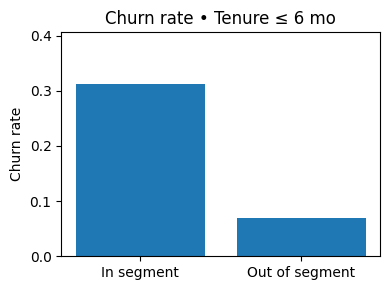

Tenure ≤ 6 mo: in=31.2%, out=6.9%, lift=1.91×, n=1272


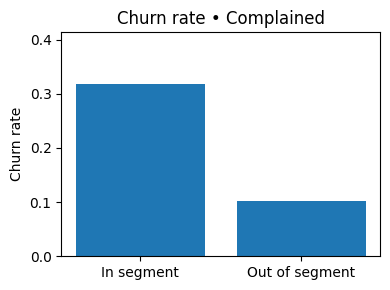

Complained: in=31.8%, out=10.3%, lift=1.95×, n=921


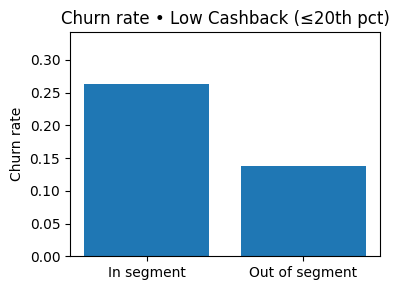

Low Cashback (≤20th pct): in=26.3%, out=13.8%, lift=1.61×, n=654


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# typed series (don't mutate df)
churn = pd.to_numeric(df["Churn"], errors="coerce").fillna(0).astype(int)
baseline = churn.mean()

def plot_segment(mask, name, baseline=baseline, figsize=(4,3)):
    """
    Show churn in vs out for a boolean segment mask over df.
    Uses the typed `churn` Series above (so df isn't modified).
    """
    # coerce mask to boolean aligned with df
    mask = pd.Series(mask, index=df.index).fillna(False).astype(bool)

    # guard against empty/degenerate segments
    n_in = int(mask.sum())
    if n_in == 0 or n_in == len(df):
        print(f"Skip '{name}': segment too small or identical to full set.")
        return None

    rate_in  = churn[mask].mean()
    rate_out = churn[~mask].mean()
    lift     = (rate_in / baseline) if baseline > 0 else np.nan

    plt.figure(figsize=figsize)
    plt.bar(["In segment", "Out of segment"], [rate_in, rate_out])
    plt.title(f"Churn rate • {name}")
    plt.ylabel("Churn rate")
    plt.ylim(0, max(rate_in, rate_out) * 1.3)
    plt.tight_layout()
    plt.show()

    print(f"{name}: in={rate_in:.1%}, out={rate_out:.1%}, lift={lift:.2f}×, n={n_in}")
    return {"segment": name, "n": n_in, "churn_in": rate_in,
            "churn_out": rate_out, "lift": lift, "baseline": baseline}

# --- call it for your top segments ---
if "Tenure" in df.columns:
    plot_segment(df["Tenure"] <= 6, "Tenure ≤ 6 mo")

if "Complain" in df.columns:
    comp = pd.to_numeric(df["Complain"], errors="coerce").fillna(0).astype(int)
    plot_segment(comp == 1, "Complained")

if "CashbackAmount" in df.columns:
    q20 = df["CashbackAmount"].quantile(0.20)
    plot_segment(df["CashbackAmount"] <= q20, "Low Cashback (≤20th pct)")



Churn rate by PreferedOrderCat (with sample sizes):


,churn_rate_pct,count
PreferedOrderCat,,
Mobile Phone,27.0,1183
Fashion,15.5,484
Laptop & Accessory,9.8,1213
Others,7.4,149
Grocery,4.1,241


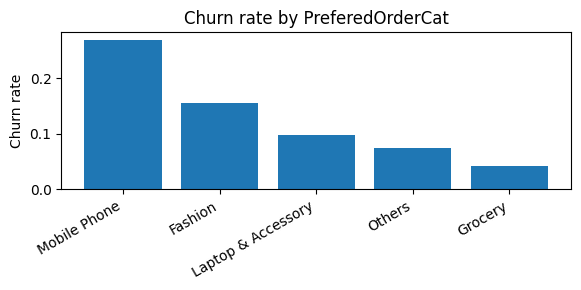

In [12]:
def _norm_cat(s: pd.Series) -> pd.Series:
    # robust: trim, collapse spaces, and map (case-insensitive) 'mobile' -> 'Mobile Phone'
    return (s.astype(str)
             .str.strip()
             .str.replace(r"\s+", " ", regex=True)
             .str.replace(r"(?i)^mobile$", "Mobile Phone", regex=True))

c = "PreferedOrderCat"
if c in df.columns:
    # work on temporaries so we don't mutate df
    cat = _norm_cat(df[c])
    churn = pd.to_numeric(df["Churn"], errors="coerce").fillna(0).astype(int)

    tmp = pd.DataFrame({c: cat, "Churn": churn})

    counts = tmp[c].value_counts(dropna=False)
    rates  = tmp.groupby(c, dropna=False)["Churn"].mean().sort_values(ascending=False)

    print(f"\nChurn rate by {c} (with sample sizes):")
    display(pd.DataFrame({
        "churn_rate_pct": (rates * 100).round(1),
        "count": counts.reindex(rates.index).astype(int)
    }))

    plt.figure(figsize=(6,3))
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Churn rate by {c}")
    plt.ylabel("Churn rate")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{c}' not in dataframe.")


DSLO ≥ 15 days  |  pop=1.2%  churn=5.0%
DSLO ≥ 30 days  |  pop=0.1%  churn=33.3%
DSLO ≥ 45 days  |  pop=0.0%  churn=100.0%

Churn by Warehouse→Home distance:


/tmp/ipython-input-1468188847.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = tmp.groupby("_bin", dropna=False)["Churn"].mean()


,churn_rate_pct
_bin,
0-5,16.7
5-10,13.5
10-15,16.0
15-25,18.2
25-50,20.9
NaN,0.0


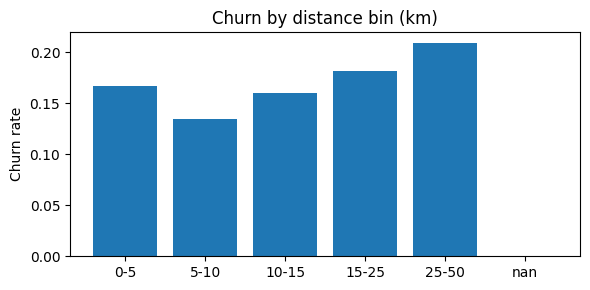


Churn by tenure band:


/tmp/ipython-input-1468188847.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trate = tmp.groupby("_ten", dropna=False)["Churn"].mean()


,churn_rate_pct
_ten,
New(≤6),31.2
Growing(6-12),9.8
Established(12-24),5.8
Veteran(>24),0.0


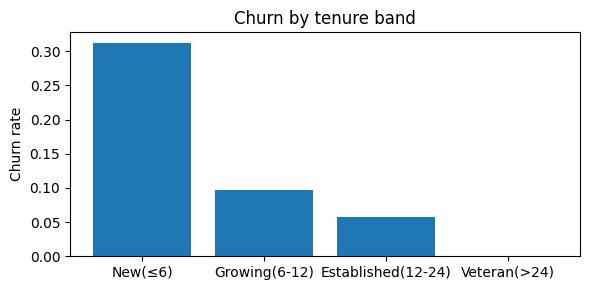

In [13]:
churn = pd.to_numeric(df["Churn"], errors="coerce").fillna(0).astype(int)

# --- Inactivity thresholds (Days Since Last Order) ---
if "DaySinceLastOrder" in df.columns:
    dslo = pd.to_numeric(df["DaySinceLastOrder"], errors="coerce")
    for d in [15, 30, 45, 60, 90]:
        mask = dslo >= d
        n = int(mask.sum())
        if n:
            print(f"DSLO ≥ {d:>2} days  |  pop={n/len(df):.1%}  churn={churn[mask].mean():.1%}")
else:
    print("DaySinceLastOrder not in dataframe.")

# --- Distance bins (Warehouse → Home) ---
if "WarehouseToHome" in df.columns:
    dist = pd.to_numeric(df["WarehouseToHome"], errors="coerce")
    bins   = [0, 5, 10, 15, 25, 50]
    labels = ["0-5","5-10","10-15","15-25","25-50"]
    tmp = pd.DataFrame({
        "_bin": pd.cut(dist, bins=bins, labels=labels, include_lowest=True),
        "Churn": churn
    })
    rate = tmp.groupby("_bin", dropna=False)["Churn"].mean()
    print("\nChurn by Warehouse→Home distance:")
    display((rate*100).round(1).to_frame("churn_rate_pct"))

    plt.figure(figsize=(6,3))
    plt.bar(rate.index.astype(str), rate.values)
    plt.title("Churn by distance bin (km)")
    plt.ylabel("Churn rate")
    plt.tight_layout()
    plt.show()
else:
    print("WarehouseToHome not in dataframe.")

# --- Tenure bands ---
if "Tenure" in df.columns:
    tenure = pd.to_numeric(df["Tenure"], errors="coerce")
    tbins   = [-0.1, 6, 12, 24, 999]
    tlabels = ["New(≤6)","Growing(6-12)","Established(12-24)","Veteran(>24)"]
    tmp = pd.DataFrame({
        "_ten": pd.cut(tenure, bins=tbins, labels=tlabels),
        "Churn": churn
    })
    trate = tmp.groupby("_ten", dropna=False)["Churn"].mean()
    print("\nChurn by tenure band:")
    display((trate*100).round(1).to_frame("churn_rate_pct"))

    plt.figure(figsize=(6,3))
    plt.bar(trate.index.astype(str), trate.values)
    plt.title("Churn by tenure band")
    plt.ylabel("Churn rate")
    plt.tight_layout()
    plt.show()
else:
    print("Tenure not in dataframe.")

In [14]:
from sklearn.metrics import roc_auc_score

# correlations
corr = df[numeric_cols + ["Churn"]].corr()["Churn"].drop("Churn").sort_values(ascending=False)
print("Correlation with Churn:"); display(corr.round(3))

# univariate AUC per numeric (higher = better monotonic separation)
auc_rows = []
for c in numeric_cols:
    x = df[c].values
    y = df["Churn"].values
    # handle NaNs safely
    mask = ~np.isnan(x)
    if mask.sum() > 0 and len(np.unique(x[mask])) > 1:
        auc = roc_auc_score(y[mask], x[mask])
        # direction doesn’t matter; keep max(auc, 1-auc)
        auc = max(auc, 1 - auc)
        auc_rows.append((c, round(auc,3)))
univar_auc = pd.DataFrame(auc_rows, columns=["feature","univariate_auc"]).sort_values("univariate_auc", ascending=False)
print("\nUnivariate AUC (numeric):"); display(univar_auc)

Correlation with Churn:


,Churn
Complain,0.262
NumberOfDeviceRegistered,0.110
SatisfactionScore,0.098
WarehouseToHome_was_missing,0.095
Tenure_was_missing,0.084
WarehouseToHome,0.066
NumberOfAddress,0.046
DaySinceLastOrder_was_missing,0.002
DaySinceLastOrder,-0.143
CashbackAmount,-0.151



Univariate AUC (numeric):


,feature,univariate_auc
0,Tenure,0.801
5,Complain,0.660
7,CashbackAmount,0.633
6,DaySinceLastOrder,0.630
2,NumberOfDeviceRegistered,0.577
3,SatisfactionScore,0.574
1,WarehouseToHome,0.555
4,NumberOfAddress,0.526
10,WarehouseToHome_was_missing,0.526
9,Tenure_was_missing,0.524


Feature engineering


In [15]:
# 0) Start from the cleaned frame
df_fe = df.copy()  # keep EDA df intact

# 1) Thresholds
thr = {
    "tenure_early_max": 6,
    "distance_far_min": 15,
    "sat_low_max": 3,
    "cashback_q20": float(df_fe["CashbackAmount"].quantile(0.20)),
}

# 2) Engineered features (idempotent; no re-normalization here)
df_fe["EarlyTenure"]       = (df_fe["Tenure"] <= thr["tenure_early_max"]).astype(int)
df_fe["TenureBand"]        = pd.cut(df_fe["Tenure"], [-0.1,6,12,24,np.inf],
                                    labels=["≤6","6–12","12–24",">24"]).astype(str)
df_fe["FarFromWarehouse"]  = (df_fe["WarehouseToHome"] >= thr["distance_far_min"]).astype(int)
df_fe["LowCashback"]       = (df_fe["CashbackAmount"] <= thr["cashback_q20"]).astype(int)
df_fe["DevicesPerAddress"] = (df_fe["NumberOfDeviceRegistered"] /
                              df_fe["NumberOfAddress"].clip(lower=1))
df_fe["LowSatisfaction"]   = (df_fe["SatisfactionScore"] <= thr["sat_low_max"]).astype(int)
df_fe["Complain_LowSat"]   = ((df_fe["Complain"] == 1) & (df_fe["LowSatisfaction"] == 1)).astype(int)

# 3) Save engineered data
fe_path = "/content/clean_ecommerce_churn_ready_fe.csv"
df_fe.to_csv(fe_path, index=False)
print(f"Saved → {fe_path} (rows: {len(df_fe)}, cols: {df_fe.shape[1]})")

# 4) Update meta for modeling/UI (built from df_fe)
meta_path = "/content/clean_meta_ready.json"
with open(meta_path) as f:
    meta = json.load(f)

num_cols = [c for c in df_fe.columns if pd.api.types.is_numeric_dtype(df_fe[c]) and c != "Churn"]
cat_cols = [c for c in df_fe.columns if df_fe[c].dtype == "object"]
ui_options = {c: sorted(df_fe[c].dropna().astype(str).unique().tolist()) for c in cat_cols}

meta.update({
    "target_col": "Churn",
    "numeric_cols": num_cols,
    "categorical_cols": cat_cols,
    "ui_options": ui_options,
    "engineered_features": [
        "EarlyTenure","TenureBand","FarFromWarehouse","LowCashback",
        "DevicesPerAddress","LowSatisfaction","Complain_LowSat"
    ],
    "feature_thresholds": thr
})

with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print(f"Updated → {meta_path}")

Saved → /content/clean_ecommerce_churn_ready_fe.csv (rows: 3270, cols: 21)
Updated → /content/clean_meta_ready.json


Model training

Logistic regression as baseline

In [16]:
# assumes you've already run the FE cell so these files exist
import json, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, fbeta_score, confusion_matrix, classification_report

# 1) Load engineered data + meta
df_fe = pd.read_csv("/content/clean_ecommerce_churn_ready_fe.csv")
meta  = json.load(open("/content/clean_meta_ready.json"))

target = meta["target_col"]
num    = meta["numeric_cols"]
cat    = meta["categorical_cols"]

X = df_fe[num + cat]
y = df_fe[target].astype(int)

# 2) Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Preprocess + model
prep = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",  StandardScaler(with_mean=False))]), num),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat),
])

clf  = LogisticRegression(max_iter=2000, class_weight="balanced")
pipe = Pipeline([("prep", prep), ("clf", clf)]).fit(X_tr, y_tr)

# 4) Evaluate + pick recall-oriented threshold (F2)
p_te = pipe.predict_proba(X_te)[:, 1]
roc  = roc_auc_score(y_te, p_te)
pr   = average_precision_score(y_te, p_te)

ts  = np.linspace(0.05, 0.95, 181)
f2s = [fbeta_score(y_te, (p_te >= t).astype(int), beta=2) for t in ts]
best_t = float(ts[int(np.argmax(f2s))])

print(f"ROC AUC: {roc:.3f} | PR AUC: {pr:.3f} | Best F2: {max(f2s):.3f} @ thr={best_t:.2f}")
print(confusion_matrix(y_te, (p_te>=best_t).astype(int)))
print(classification_report(y_te, (p_te>=best_t).astype(int), digits=3))

# 5) Save model + threshold back to meta (used by Gradio)
joblib.dump(pipe, "/content/churn_pipe.joblib")
meta["decision_threshold"] = best_t
json.dump(meta, open("/content/clean_meta_ready.json","w"), indent=2)
print("Saved → /content/churn_pipe.joblib and updated decision_threshold in meta.")

ROC AUC: 0.927 | PR AUC: 0.710 | Best F2: 0.784 @ thr=0.57
[[459  88]
 [ 11  96]]
              precision    recall  f1-score   support

           0      0.977     0.839     0.903       547
           1      0.522     0.897     0.660       107

    accuracy                          0.849       654
   macro avg      0.749     0.868     0.781       654
weighted avg      0.902     0.849     0.863       654

Saved → /content/churn_pipe.joblib and updated decision_threshold in meta.


Profit optimal threshold

In [17]:
# Profit-optimal threshold (on engineered data)
import json, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, precision_score

# Business knobs (tune to your case)
cost_contact   = 1.0    # $ per outreach
benefit_saved  = 60.0   # $ value if a churner is retained
save_rate      = 0.25   # share of contacted true churners you actually save

# Load engineered data / meta / trained model (reuse df_fe if present)
try:
    _ = df_fe
except NameError:
    df_fe = pd.read_csv("/content/clean_ecommerce_churn_ready_fe.csv")

meta = json.load(open("/content/clean_meta_ready.json"))
pipe = joblib.load("/content/churn_pipe.joblib")

target = meta["target_col"]
num, cat = meta["numeric_cols"], meta["categorical_cols"]

X = df_fe[num + cat]
y = df_fe[target].astype(int)

_, X_te, _, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
p = pipe.predict_proba(X_te)[:, 1]

prec, rec, ts = precision_recall_curve(y_te, p)
ts = np.r_[ts, 1.0]  # align with prec/rec lengths

# Expected profit per contacted customer at threshold t
net_per_flag = prec * save_rate * benefit_saved - cost_contact
n_flagged = np.array([(p >= t).sum() for t in ts])
net_total = net_per_flag * n_flagged

best_i = int(np.argmax(net_total))
thr_profit = float(ts[best_i])

print(f"Profit-optimal threshold: {thr_profit:.2f}")
print(f"Expected net ≈ ${net_total[best_i]:.0f} | flagged={int(n_flagged[best_i])} "
      f"| precision={prec[best_i]:.2f} | recall={rec[best_i]:.2f}")

# Compare to your saved F2 threshold (if any)
saved_t = meta.get("decision_threshold", None)
if saved_t is not None:
    yhat_saved = (p >= saved_t).astype(int)
    prec_saved = precision_score(y_te, yhat_saved, zero_division=0)
    net_per_flag_saved = prec_saved * save_rate * benefit_saved - cost_contact
    saved_net = net_per_flag_saved * int((p >= saved_t).sum())
    print(f"F2 threshold (meta): {saved_t:.2f} | expected net ≈ ${saved_net:,.0f}")

# Context: confusion matrix at profit-opt threshold
yhat = (p >= thr_profit).astype(int)
print("\nConfusion matrix @ profit-opt threshold:")
print(confusion_matrix(y_te, yhat))
print("\nClassification report:")
print(classification_report(y_te, yhat, digits=3))

Profit-optimal threshold: 0.39
Expected net ≈ $1270 | flagged=275 | precision=0.37 | recall=0.96
F2 threshold (meta): 0.57 | expected net ≈ $1,256

Confusion matrix @ profit-opt threshold:
[[375 172]
 [  4 103]]

Classification report:
              precision    recall  f1-score   support

           0      0.989     0.686     0.810       547
           1      0.375     0.963     0.539       107

    accuracy                          0.731       654
   macro avg      0.682     0.824     0.675       654
weighted avg      0.889     0.731     0.766       654



Which features drive the prediction

In [18]:
# === Refit transparent logistic + export drivers for the app ===
import json, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1) Load engineered data + meta
df   = pd.read_csv("/content/clean_ecommerce_churn_ready_fe.csv")
meta = json.load(open("/content/clean_meta_ready.json"))

target = meta["target_col"]

# Use TenureBand (categorical) instead of raw Tenure/EarlyTenure to reduce collinearity
num = [c for c in meta["numeric_cols"] if c not in ["Tenure","EarlyTenure"]]
cat = sorted(set(meta["categorical_cols"]) | {"TenureBand"})

X = df[num + cat]
y = df[target].astype(int)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

prep = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler(with_mean=False)),
    ]), num),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]), cat),
])

clf  = LogisticRegression(max_iter=2000, class_weight="balanced")
pipe = Pipeline([("prep", prep), ("clf", clf)]).fit(Xtr, ytr)

print("Refit ROC AUC:", roc_auc_score(yte, pipe.predict_proba(Xte)[:,1]))

# 2) Build drivers table (coef + odds ratio)
ohe = pipe.named_steps["prep"].transformers_[1][1].named_steps["ohe"]
feat_names = np.r_[num, ohe.get_feature_names_out(cat)]
coefs      = pipe.named_steps["clf"].coef_.ravel()
odds       = np.exp(coefs)

drivers = (pd.DataFrame({"feature": feat_names, "coef": coefs, "odds_ratio": odds})
             .sort_values("coef", ascending=False)
             .reset_index(drop=True))

display(drivers.head(10))   # quick peek

# 3) Save for Hugging Face Space
payload = {
    "table": drivers.to_dict(orient="records"),
    "created_utc": __import__("time").time(),
    "note": "Computed in Colab; TenureBand used; raw Tenure/EarlyTenure excluded to reduce multicollinearity."
}
with open("/content/model_drivers.json", "w") as f:
    json.dump(payload, f, indent=2)

print("Saved → /content/model_drivers.json")

Refit ROC AUC: 0.9140767824497258


,feature,coef,odds_ratio
0,TenureBand_≤6,2.241682,9.409148
1,PreferedOrderCat_Others,1.724505,5.609745
2,Complain,0.711740,2.037533
3,MaritalStatus_Single,0.545332,1.725180
4,PreferedOrderCat_Fashion,0.460363,1.584649
5,NumberOfDeviceRegistered,0.421955,1.524939
6,Tenure_was_missing,0.372876,1.451904
7,SatisfactionScore,0.366688,1.442948
8,TenureBand_6–12,0.259480,1.296256
9,NumberOfAddress,0.232811,1.262143


Saved → /content/model_drivers.json


In [19]:
!pip install -qU \
  pandas==2.2.2 \
  numpy==2.0.2 \
  scikit-learn==1.6.1 \
  gradio==5.44.1 \
  websockets==15.0.1 \
  joblib==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 16.1 MB/s eta 0:00:00


In [20]:
import os, json, joblib, gradio as gr
from pathlib import Path

gr.close_all()  # frees ports from any previous demo

META_PATH  = Path("clean_meta_ready.json")
MODEL_PATH = Path("churn_pipe.joblib")
DRIVERS_JSON_PATH = Path("model_drivers.json")  # optional

assert META_PATH.exists(), f"Missing {META_PATH.resolve()}"
meta = json.load(open(META_PATH))

# Load model (or from HF Hub if you set env vars MODEL_REPO / MODEL_FILENAME)
if MODEL_PATH.exists():
    pipe = joblib.load(MODEL_PATH)
else:
    MODEL_REPO = os.getenv("MODEL_REPO", "")
    MODEL_FILENAME = os.getenv("MODEL_FILENAME", "churn_pipe.joblib")
    if MODEL_REPO:
        from huggingface_hub import hf_hub_download
        fp = hf_hub_download(repo_id=MODEL_REPO, filename=MODEL_FILENAME)
        pipe = joblib.load(fp)
    else:
        raise FileNotFoundError(f"Model not found: {MODEL_PATH.resolve()}")

thr_f2 = float(meta.get("decision_threshold", 0.5))
thr_profit_default = float(meta.get("decision_threshold_profit_opt", thr_f2))
feat_thr = meta.get("feature_thresholds", {})

EXPECTED_NUM = meta["numeric_cols"]
EXPECTED_CAT = meta["categorical_cols"]
EXPECTED_ALL = EXPECTED_NUM + EXPECTED_CAT

REQUIRED_COLS = [
    "Tenure","WarehouseToHome","NumberOfDeviceRegistered","SatisfactionScore",
    "MaritalStatus","NumberOfAddress","Complain","DaySinceLastOrder",
    "CashbackAmount","PreferedOrderCat"
]

In [21]:
import pandas as pd
import numpy as np

def normalize_categories(df: pd.DataFrame) -> pd.DataFrame:
    if "PreferedOrderCat" in df.columns:
        df["PreferedOrderCat"] = (
            df["PreferedOrderCat"].astype(str)
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.replace(r"(?i)^mobile$", "Mobile Phone", regex=True)
        )
    return df

def normalize_complain(col) -> pd.Series:
    def _to_int(v):
        s = str(v).strip().lower()
        return 1 if s in {"1","yes","y","true","t"} else 0
    return pd.Series([_to_int(v) for v in col])

def add_missing_flags(r: pd.DataFrame) -> pd.DataFrame:
    for base in ["DaySinceLastOrder","Tenure","WarehouseToHome"]:
        col = f"{base}_was_missing"
        if col not in r.columns:
            r[col] = r[base].isna().astype(int) if base in r.columns else 1
    return r

def engineer(df_row: pd.DataFrame) -> pd.DataFrame:
    r = df_row.copy()
    r = normalize_categories(r)
    t_early = feat_thr.get("tenure_early_max", 6)
    d_far   = feat_thr.get("distance_far_min", 15)
    sat_lo  = feat_thr.get("sat_low_max", 3)
    cb_q20  = feat_thr.get("cashback_q20", float(r["CashbackAmount"].quantile(0.20)))

    for c in ["Tenure","WarehouseToHome","NumberOfDeviceRegistered",
              "SatisfactionScore","NumberOfAddress","DaySinceLastOrder","CashbackAmount"]:
        if c in r.columns:
            r[c] = pd.to_numeric(r[c], errors="coerce")

    r["EarlyTenure"]       = (r["Tenure"] <= t_early).astype(int)
    r["TenureBand"]        = pd.cut(r["Tenure"], [-0.1,6,12,24,np.inf], labels=["≤6","6–12","12–24",">24"]).astype(str)
    r["FarFromWarehouse"]  = (r["WarehouseToHome"] >= d_far).astype(int)
    r["LowCashback"]       = (r["CashbackAmount"] <= cb_q20).astype(int)
    r["DevicesPerAddress"] = r["NumberOfDeviceRegistered"] / r["NumberOfAddress"].clip(lower=1)
    r["LowSatisfaction"]   = (r["SatisfactionScore"] <= sat_lo).astype(int)
    if "Complain" in r.columns:
        r["Complain"] = pd.to_numeric(r["Complain"], errors="coerce").fillna(0).astype(int)
    r["Complain_LowSat"]   = ((r["Complain"]==1) & (r["LowSatisfaction"]==1)).astype(int)
    return r

def align_to_training_columns(r: pd.DataFrame) -> pd.DataFrame:
    out = r.copy()
    for c in EXPECTED_ALL:
        if c not in out.columns:
            out[c] = 0 if c in EXPECTED_NUM else ""
    for c in EXPECTED_NUM:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0)
    for c in EXPECTED_CAT:
        out[c] = out[c].astype(str)
    return out[EXPECTED_ALL]

def flags_for_row(s: pd.Series) -> str:
    msgs = []
    if s.get("EarlyTenure", 0) == 1:         msgs.append("Early tenure (≤6 mo)")
    if s.get("Complain", 0) == 1:           msgs.append("Recent complaint")
    if s.get("LowCashback", 0) == 1:        msgs.append("Low cashback (≤Q20)")
    if s.get("FarFromWarehouse", 0) == 1:   msgs.append("Far from warehouse (≥15 km)")
    if s.get("Complain_LowSat", 0) == 1:    msgs.append("Complaint + Low satisfaction")
    return " | ".join(msgs) if msgs else "No risk flags"

def choose_threshold(mode: str, custom_thr: float, profit_thr: float) -> float:
    if mode == "Recall (F2)":
        return thr_f2
    if mode == "Profit (ROI)":
        return float(profit_thr)
    return float(custom_thr)


In [22]:
import gradio as gr

def predict_fn(
    Tenure, WarehouseToHome, NumberOfDeviceRegistered, SatisfactionScore,
    MaritalStatus, NumberOfAddress, Complain, DaySinceLastOrder,
    CashbackAmount, PreferedOrderCat, threshold_mode, custom_threshold, profit_threshold
):
    row = pd.DataFrame([{
        "Tenure": Tenure,
        "WarehouseToHome": WarehouseToHome,
        "NumberOfDeviceRegistered": NumberOfDeviceRegistered,
        "SatisfactionScore": SatisfactionScore,
        "MaritalStatus": MaritalStatus,
        "NumberOfAddress": NumberOfAddress,
        "Complain": 1 if Complain=="Yes" else 0,
        "DaySinceLastOrder": DaySinceLastOrder,
        "CashbackAmount": CashbackAmount,
        "PreferedOrderCat": PreferedOrderCat,
        "Churn": 0
    }])

    row = engineer(row)
    row = add_missing_flags(row)
    X = align_to_training_columns(row)

    proba = float(pipe.predict_proba(X)[:,1][0])
    thr = choose_threshold(threshold_mode, custom_threshold, profit_threshold)
    decision = "Flag for retention" if proba >= thr else "Low risk"
    flags = flags_for_row(row.iloc[0])
    return f"{proba:.1%}", f"{decision} (thr = {thr:.2f})", flags

def batch_predict_fn(file, threshold_mode, custom_threshold, profit_threshold):
    if file is None:
        raise gr.Error("Please upload a CSV file.")

    df_raw = pd.read_csv(file.name)
    missing = [c for c in REQUIRED_COLS if c not in df_raw.columns]
    if missing:
        raise gr.Error("Missing required columns: " + ", ".join(missing)
                       + "\nExpected: " + ", ".join(REQUIRED_COLS))

    df_raw = df_raw.copy()
    df_raw["Complain"] = normalize_complain(df_raw["Complain"])
    df_raw = normalize_categories(df_raw)
    for c in ["Tenure","WarehouseToHome","NumberOfDeviceRegistered","SatisfactionScore",
              "NumberOfAddress","DaySinceLastOrder","CashbackAmount"]:
        if c in df_raw.columns:
            df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

    df_fe = engineer(df_raw)
    df_fe = add_missing_flags(df_fe)
    X = align_to_training_columns(df_fe)

    proba = pipe.predict_proba(X)[:,1]
    thr = choose_threshold(threshold_mode, custom_threshold, profit_threshold)
    decision = np.where(proba >= thr, "Flag for retention", "Low risk")
    flags = df_fe.apply(flags_for_row, axis=1)

    out = df_raw.copy()
    out["Churn_Proba"] = np.round(proba, 4)
    out["Decision"] = decision
    out["RiskFlags"] = flags

    out_path = "/tmp/churn_scored.csv"
    out.to_csv(out_path, index=False)

    preview = out.head(25)
    return preview, out_path


In [23]:
%%writefile /content/app.py

import gradio as gr
import pandas as pd

def load_drivers_df():
    if DRIVERS_JSON_PATH.exists():
        try:
            df = pd.read_json(DRIVERS_JSON_PATH)
            if "coef" in df.columns:
                df = df.sort_values("coef", ascending=False)
            return df
        except Exception:
            pass
    return pd.DataFrame(columns=["feature","coef","odds_ratio"])

drivers_df = load_drivers_df()

cat_opts = meta.get("ui_options", {})
marital_choices = cat_opts.get("MaritalStatus", ["Married","Single","Divorced"])
cat_choices = cat_opts.get("PreferedOrderCat", ["Laptop & Accessory","Mobile Phone","Fashion","Grocery","Others"])

with gr.Blocks(title="E-commerce Churn Predictor") as demo:
    gr.Markdown("## E-commerce Churn Predictor\nGet churn probability, a decision flag, and **why** (risk flags).")

    with gr.Tab("Single prediction"):
        with gr.Row():
            with gr.Column():
                Tenure = gr.Slider(0, 60, value=6, step=1, label="Tenure (months)")
                WarehouseToHome = gr.Slider(0, 50, value=10, step=1, label="Warehouse → Home (km)")
                NumberOfDeviceRegistered = gr.Slider(1, 6, value=3, step=1, label="# Devices registered")
                SatisfactionScore = gr.Slider(1, 5, value=3, step=1, label="Satisfaction score (1–5)")
                NumberOfAddress = gr.Slider(1, 10, value=2, step=1, label="# Addresses on file")
                DaySinceLastOrder = gr.Slider(0, 90, value=7, step=1, label="Days since last order")
                CashbackAmount = gr.Slider(0, 350, value=150, step=1, label="Cashback amount")
                Complain = gr.Radio(choices=["No","Yes"], value="No", label="Complained?")
                PreferedOrderCat = gr.Dropdown(cat_choices, value=cat_choices[0], label="Preferred order category")
                MaritalStatus = gr.Dropdown(marital_choices, value=marital_choices[0], label="Marital status")

                gr.Markdown("**Decision threshold**")
                threshold_mode   = gr.Radio(["Recall (F2)", "Profit (ROI)", "Custom"], value="Recall (F2)")
                profit_threshold = gr.Slider(0.05, 0.95, step=0.01, value=thr_profit_default, label="Profit threshold")
                custom_threshold = gr.Slider(0.05, 0.95, step=0.01, value=thr_f2, label="Custom threshold")

                btn_single = gr.Button("Predict")

            with gr.Column():
                prob = gr.Textbox(label="Churn probability", interactive=False)
                dec  = gr.Textbox(label="Decision", interactive=False)
                expl = gr.Textbox(label="Why this decision (risk flags)", lines=6, interactive=False)

        btn_single.click(
            predict_fn,
            inputs=[Tenure, WarehouseToHome, NumberOfDeviceRegistered, SatisfactionScore,
                    MaritalStatus, NumberOfAddress, Complain, DaySinceLastOrder,
                    CashbackAmount, PreferedOrderCat, threshold_mode, custom_threshold, profit_threshold],
            outputs=[prob, dec, expl]
        )

    with gr.Tab("Batch (CSV)"):
        gr.Markdown(
            "Upload a CSV with these exact columns:\n\n"
            f"`{', '.join(REQUIRED_COLS)}`\n\n"
            "Tip: `Complain` can be **Yes/No** or **1/0**."
        )
        file_in = gr.File(file_types=[".csv"], label="Upload CSV")
        thr_mode_b = gr.Radio(["Recall (F2)", "Profit (ROI)", "Custom"], value="Recall (F2)", label="Decision threshold")
        profit_thr_b = gr.Slider(0.05, 0.95, step=0.01, value=thr_profit_default, label="Profit threshold")
        custom_thr_b = gr.Slider(0.05, 0.95, step=0.01, value=thr_f2, label="Custom threshold")
        btn_batch = gr.Button("Score file")

        preview_out = gr.Dataframe(label="Preview (first 25 rows)", interactive=False)
        file_out = gr.File(label="Download scored CSV")

        btn_batch.click(
            batch_predict_fn,
            inputs=[file_in, thr_mode_b, custom_thr_b, profit_thr_b],
            outputs=[preview_out, file_out]
        )

    with gr.Tab("Model drivers"):
        gr.Markdown("Top global drivers from a transparent logistic refit (odds ratios shown).")
        gr.Dataframe(value=drivers_df, interactive=False, wrap=True, label="Global drivers")

# Choose a specific port to avoid conflicts in Colab
demo.launch(server_name="0.0.0.0", server_port=7866, share=True, debug=True)


Writing /content/app.py


In [24]:
!ls -lh /content/app.py

-rw-r--r-- 1 root root 4.3K Sep 16 19:36 /content/app.py


Deploy to Hugging Face

In [25]:
%%writefile /content/requirements.txt
pandas==2.2.2
numpy==2.0.2
scikit-learn==1.6.1
gradio==5.44.1
websockets==15.0.1
joblib==1.4.2
huggingface-hub>=0.23

Writing /content/requirements.txt


In [26]:
!ls -lh /content/clean_meta_ready.json /content/churn_pipe.joblib


-rw-r--r-- 1 root root 6.3K Sep 16 19:36 /content/churn_pipe.joblib
-rw-r--r-- 1 root root 1.3K Sep 16 19:36 /content/clean_meta_ready.json


In [27]:
import json, joblib, numpy as np, pandas as pd

pipe = joblib.load("/content/churn_pipe.joblib")
meta = json.load(open("/content/clean_meta_ready.json"))

prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]

# feature names: numeric + OHE(categoricals)
num = list(meta["numeric_cols"])
ohe = prep.transformers_[1][1].named_steps["ohe"]
cat = list(meta["categorical_cols"])
feat_names = np.r_[num, ohe.get_feature_names_out(cat)]

coefs = clf.coef_.ravel()
odds  = np.exp(coefs)

drivers = pd.DataFrame({"feature": feat_names, "coef": coefs, "odds_ratio": odds}) \
            .sort_values("coef", ascending=False)

payload = {
    "top_positive": drivers.head(15).to_dict(orient="records"),
    "top_negative": drivers.tail(15).sort_values("coef").to_dict(orient="records"),
}

with open("/content/model_drivers.json", "w") as f:
    json.dump(payload, f, indent=2)

print("Saved → /content/model_drivers.json")

Saved → /content/model_drivers.json


In [27]:
# List likely app files at /content
ls -la /content

# Find common files anywhere under /content
find /content -maxdepth 3 \( -name "app.py" -o -name "requirements.txt" -o -name "*.joblib" -o -name "model_*.json" -o -name "*.ipynb" \) -type f -print


In [29]:
import os
targets = ["app.py","requirements.txt","churn_pipe.joblib","model_drivers.json"]
for t in targets:
    p = f"/content/{t}"
    print(f"{t}: {'FOUND' if os.path.exists(p) else 'missing'}")


app.py: FOUND
requirements.txt: FOUND
churn_pipe.joblib: FOUND
model_drivers.json: FOUND


In [31]:
# ==== SETUP (edit nothing below unless you change names) ====
GH_USER="tiffchow214"
GH_REPO="churn-predictor-app"                         # your existing repo
HF_SPACE_URL="https://huggingface.co/spaces/tiffcz214/ecommerce_churn_app"

# (1) Clean workspace and clone BOTH repos
%cd /content
!rm -rf hf_space gh_repo
!git lfs install
!git clone "{HF_SPACE_URL}" hf_space
!git clone "https://github.com/{GH_USER}/{GH_REPO}.git" gh_repo

# (2) Option A: put app files in a tidy subfolder inside your repo
#    (this keeps your README + notebook at root)
!mkdir -p gh_repo/app
!cp -r hf_space/* gh_repo/app/

# If you prefer everything at root, use this instead of the 3 lines above:
# !cp -r hf_space/* gh_repo/

# (3) Track large binaries (model) with Git LFS
%cd /content/gh_repo
!git lfs track "*.joblib" "*.pkl" "*.bin"
!git add .gitattributes

# (4) Commit + push to your existing GitHub repo
!git add .
!git commit -m "Add Hugging Face Space app files under /app"
!git push


/content
Git LFS initialized.
Cloning into 'hf_space'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 16), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (37/37), 18.94 KiB | 1020.00 KiB/s, done.
Cloning into 'gh_repo'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 134.17 KiB | 9.58 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/gh_repo
Tracking "*.joblib"
Tracking "*.pkl"
Tracking "*.bin"
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: una

In [33]:
# change into your repo
%cd /content/gh_repo

# show status, branch, and remotes
!git status
!git branch
!git remote -v

/content/gh_repo
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   .gitattributes
	new file:   app/README.md
	new file:   app/app.py
	new file:   app/churn_pipe.joblib
	new file:   app/clean_meta_ready.json
	new file:   app/model_drivers.json
	new file:   app/requirements.txt

* main
origin	https://github.com/tiffchow214/churn-predictor-app.git (fetch)
origin	https://github.com/tiffchow214/churn-predictor-app.git (push)
